In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import time as t

In [2]:
# function to load pickle files
def load_pickle_file(pickle_file, dataset_str, labels_str):
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        dataset = save[dataset_str]
        labels = save[labels_str]
        del save
    return dataset, labels

pkl_train = 'svhn_my_all_color_train.pickle'
pkl_test = 'svhn_my_all_color_test.pickle'
pkl_valid = 'svhn_my_all_color_valid.pickle'
train_dataset, train_labels = load_pickle_file(pkl_train, 'train_dataset', 'train_labels')
test_dataset, test_labels = load_pickle_file(pkl_test, 'test_dataset', 'test_labels')
valid_dataset, valid_labels = load_pickle_file(pkl_valid, 'valid_dataset', 'valid_labels')

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (229754, 32, 32, 3) (229754, 6)
Validation set (6000, 32, 32, 3) (6000, 6)
Test set (13068, 32, 32, 3) (13068, 6)


In [3]:
# define accuracy as performance metric to be used in this exercise
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [4]:
print(test_dataset.shape)
test_dataset_0=test_dataset[0:6534,:,:,:]
test_dataset_1=test_dataset[6534:13068,:,:,:]
#test_dataset_2=test_dataset[9000:,:,:,:]
print(test_dataset_0.shape)
print(test_dataset_1.shape)

(13068, 32, 32, 3)
(6534, 32, 32, 3)
(6534, 32, 32, 3)


In [74]:
train_labels[1]

array([ 3,  1,  6,  1, 10, 10])

In [5]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16

dropout = 0.5

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases  = tf.Variable(tf.constant(1.0, shape=[depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases  = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, num_hidden1], stddev=0.1))
    layer3_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    
    # Read Out layer
    out1_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out2_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out3_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out4_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out5_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data, keep_prob=1.0):
        h_conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID') + layer1_biases)
        h_pool1 = tf.nn.max_pool(h_conv1, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, layer2_weights, [1,1,1,1], 'VALID') + layer2_biases)
        h_pool2 = tf.nn.max_pool(h_conv2, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, layer3_weights, [1,1,1,1], 'VALID') + layer3_biases)
        
        hidden = tf.nn.dropout(h_conv3, keep_prob)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        logits1 = tf.matmul(reshape, out1_w) + out1_b
        logits2 = tf.matmul(reshape, out2_w) + out2_b
        logits3 = tf.matmul(reshape, out3_w) + out3_b
        logits4 = tf.matmul(reshape, out4_w) + out4_b
        logits5 = tf.matmul(reshape, out5_w) + out5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout)
    
    loss_1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1],logits=logits1))
    loss_2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2],logits=logits2))
    loss_3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3],logits=logits3))
    loss_4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4],logits=logits4))
    loss_5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,5],logits=logits5))
    loss   = loss_1+loss_2+loss_3+loss_4+loss_5
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    [tr_logits1, tr_logits2, tr_logits3, tr_logits4, tr_logits5] = model(tf_train_dataset)
    train_prediction = tf.stack([tf.nn.softmax(tr_logits1),\
                                tf.nn.softmax(tr_logits2),\
                                tf.nn.softmax(tr_logits3),\
                                tf.nn.softmax(tr_logits4),\
                                tf.nn.softmax(tr_logits5)])
    
    [v_logits1, v_logits2, v_logits3, v_logits4, v_logits5] = model(tf_valid_dataset)
    valid_prediction = tf.stack([tf.nn.softmax(v_logits1),\
                                tf.nn.softmax(v_logits2),\
                                tf.nn.softmax(v_logits3),\
                                tf.nn.softmax(v_logits4),\
                                tf.nn.softmax(v_logits5)])
    
    [te_logits1, te_logits2, te_logits3, te_logits4, te_logits5] = model(tf_test_dataset)
    test_prediction = tf.stack([tf.nn.softmax(te_logits1),\
                               tf.nn.softmax(te_logits2),\
                               tf.nn.softmax(te_logits3),\
                               tf.nn.softmax(te_logits4),\
                               tf.nn.softmax(te_logits5)])
    saver = tf.train.Saver()

In [17]:
num_steps = 50001

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())  
    mask = np.random.permutation(len(train_dataset))
    train_dataset=train_dataset[mask]
    train_labels = train_labels[mask]
    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)

        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, ".ipynb_checkpoints/CNN_multi_all_color_1.ckpt")
    print("Model saved in file: %s" % save_path)
#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))

#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 34.195557, Minibatch acc: 5.6%, Validation acc: 50.6%
Step: 500, Minibatch loss: 6.346583, Minibatch acc: 60.0%, Validation acc: 59.9%
Step: 1000, Minibatch loss: 5.443113, Minibatch acc: 66.6%, Validation acc: 65.8%
Step: 1500, Minibatch loss: 5.062945, Minibatch acc: 70.3%, Validation acc: 68.5%
Step: 2000, Minibatch loss: 5.162542, Minibatch acc: 69.4%, Validation acc: 69.8%
Step: 2500, Minibatch loss: 5.079070, Minibatch acc: 74.4%, Validation acc: 72.6%
Step: 3000, Minibatch loss: 4.678633, Minibatch acc: 74.4%, Validation acc: 73.5%
Step: 3500, Minibatch loss: 4.310670, Minibatch acc: 78.1%, Validation acc: 76.0%
Step: 4000, Minibatch loss: 5.057773, Minibatch acc: 72.8%, Validation acc: 76.7%
Step: 4500, Minibatch loss: 4.058660, Minibatch acc: 79.4%, Validation acc: 77.3%
Step: 5000, Minibatch loss: 3.799094, Minibatch acc: 82.5%, Validation acc: 77.3%
Step: 5500, Minibatch loss: 4.318065, Minibatch acc: 74.7%, Validation acc: 78.4%
Step: 60

Step: 49500, Minibatch loss: 2.955132, Minibatch acc: 86.6%, Validation acc: 85.8%
Step: 50000, Minibatch loss: 3.183448, Minibatch acc: 87.5%, Validation acc: 85.8%
Model saved in file: .ipynb_checkpoints/CNN_multi_all_color_1.ckpt
Time to train: 218.44
Model train complete


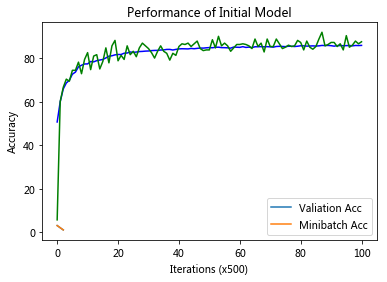

In [18]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.xlabel('Iterations (x500)')
plt.ylabel('Accuracy')
plt.title('Performance of Initial Model')
line_up, = plt.plot([3,2,1], label='Valiation Acc')
line_down, = plt.plot([3,2,1], label='Minibatch Acc')
plt.legend(handles=[line_up, line_down],loc=4)
plt.show()

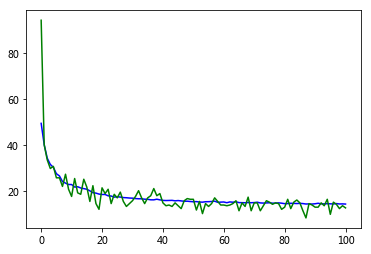

In [19]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [21]:
# restore model to calculate accuracy
with tf.Session(graph=graph) as session:
    saver.restore(session, ".ipynb_checkpoints/CNN_multi_all_color_1.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')


INFO:tensorflow:Restoring parameters from .ipynb_checkpoints/CNN_multi_all_color_1.ckpt
Model restored.
Initialized
Done


In [22]:
# calculate accuracy
acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

87.8726660545 87.9400061218
Test accuracy: 87.91


In [25]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16

dropout = 0.5


graph = tf.Graph()

with graph.as_default():


    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases  = tf.Variable(tf.constant(1.0, shape=[depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases  = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, num_hidden1], stddev=0.1))
    layer3_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    
    # Read Out layer
    out1_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out2_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out3_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out4_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out5_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    out5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset_0)
  
    # Model.
    def model(data, keep_prob=1.0):
        h_conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID') + layer1_biases)
        lrn = tf.nn.local_response_normalization(h_conv1)
        h_pool1 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, layer2_weights, [1,1,1,1], 'VALID') + layer2_biases)
        lrn = tf.nn.local_response_normalization(h_conv2)
        h_pool2 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, layer3_weights, [1,1,1,1], 'VALID') + layer3_biases)
        
        hidden = tf.nn.dropout(h_conv3, keep_prob)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        logits1 = tf.matmul(reshape, out1_w) + out1_b
        logits2 = tf.matmul(reshape, out2_w) + out2_b
        logits3 = tf.matmul(reshape, out3_w) + out3_b
        logits4 = tf.matmul(reshape, out4_w) + out4_b
        logits5 = tf.matmul(reshape, out5_w) + out5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout)
    
    loss_1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1],logits=logits1))
    loss_2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2],logits= logits2))
    loss_3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3],logits=logits3))
    loss_4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4],logits=logits4))
    loss_5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,5],logits=logits5))
    loss   = loss_1+loss_2+loss_3+loss_4+loss_5
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.1, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    [tr_logits1, tr_logits2, tr_logits3, tr_logits4, tr_logits5] = model(tf_train_dataset)
    train_prediction = tf.stack([tf.nn.softmax(tr_logits1),\
                                tf.nn.softmax(tr_logits2),\
                                tf.nn.softmax(tr_logits3),\
                                tf.nn.softmax(tr_logits4),\
                                tf.nn.softmax(tr_logits5)])
    
    [v_logits1, v_logits2, v_logits3, v_logits4, v_logits5] = model(tf_valid_dataset)
    valid_prediction = tf.stack([tf.nn.softmax(v_logits1),\
                                tf.nn.softmax(v_logits2),\
                                tf.nn.softmax(v_logits3),\
                                tf.nn.softmax(v_logits4),\
                                tf.nn.softmax(v_logits5)])
    
    [te_logits1, te_logits2, te_logits3, te_logits4, te_logits5] = model(tf_test_dataset)
    test_prediction = tf.stack([tf.nn.softmax(te_logits1),\
                               tf.nn.softmax(te_logits2),\
                               tf.nn.softmax(te_logits3),\
                               tf.nn.softmax(te_logits4),\
                               tf.nn.softmax(te_logits5)])
    saver = tf.train.Saver()
    

In [28]:
num_steps = 50000

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())  

    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, ".ipynb_checkpoints/CNN_multi_all_color_2.ckpt")
    print("Model saved in file: %s" % save_path)

#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))

#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 13.448040, Minibatch acc: 5.9%, Validation acc: 54.9%
Step: 500, Minibatch loss: 6.255790, Minibatch acc: 56.2%, Validation acc: 57.8%
Step: 1000, Minibatch loss: 4.848320, Minibatch acc: 73.8%, Validation acc: 71.7%
Step: 1500, Minibatch loss: 3.813748, Minibatch acc: 77.5%, Validation acc: 79.4%
Step: 2000, Minibatch loss: 4.320168, Minibatch acc: 78.4%, Validation acc: 81.9%
Step: 2500, Minibatch loss: 3.526679, Minibatch acc: 85.0%, Validation acc: 83.9%
Step: 3000, Minibatch loss: 3.197514, Minibatch acc: 85.6%, Validation acc: 85.7%
Step: 3500, Minibatch loss: 3.173956, Minibatch acc: 87.2%, Validation acc: 86.2%
Step: 4000, Minibatch loss: 3.547915, Minibatch acc: 83.4%, Validation acc: 87.2%
Step: 4500, Minibatch loss: 2.951021, Minibatch acc: 88.4%, Validation acc: 87.9%
Step: 5000, Minibatch loss: 2.364114, Minibatch acc: 90.0%, Validation acc: 88.3%
Step: 5500, Minibatch loss: 2.731525, Minibatch acc: 89.4%, Validation acc: 88.4%
Step: 60

Step: 49500, Minibatch loss: 1.742140, Minibatch acc: 93.1%, Validation acc: 92.7%
Model saved in file: .ipynb_checkpoints/CNN_multi_all_color_2.ckpt
Time to train: 269.01
Model train complete


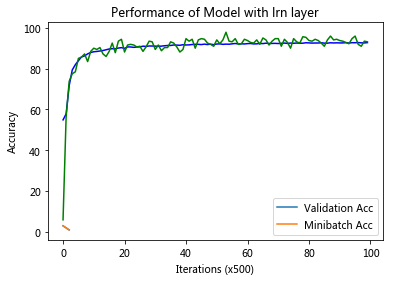

In [29]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.xlabel('Iterations (x500)')
plt.ylabel('Accuracy')
plt.title('Performance of Model with lrn layer')
line_up, = plt.plot([3,2,1], label='Validation Acc')
line_down, = plt.plot([3,2,1], label='Minibatch Acc')
plt.legend(handles=[line_up, line_down],loc=4)

plt.show()


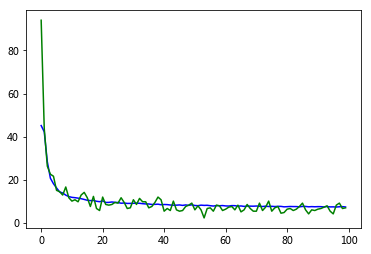

In [30]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [32]:
# reload model to calculate accuracy
with tf.Session(graph=graph) as session:
    saver.restore(session, ".ipynb_checkpoints/CNN_multi_all_color_2.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')


INFO:tensorflow:Restoring parameters from .ipynb_checkpoints/CNN_multi_all_color_2.ckpt
Model restored.
Initialized
Done


In [33]:
# calculate accuracy
acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

93.4833180288 93.3486378941
Test accuracy: 93.42


In [35]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
#num_hidden2 = 16
shape = [batch_size, image_size, image_size, num_channels]
dropout = 0.5


graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s3_w = tf.Variable(tf.truncated_normal([num_hidden1, num_labels], stddev=0.1))
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
    s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
    s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')


    # Model.
    def model(data, keep_prob, shape):
        conv = tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        #hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout, shape)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits2, labels=tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits3, labels=tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits4, labels=tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits5, labels=tf_train_labels[:,5]))
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.stack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
    valid_prediction = tf.stack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
    test_prediction = tf.stack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])

    saver = tf.train.Saver()
    

In [36]:
num_steps = 50001

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())  

    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, ".ipynb_checkpoints/CNN_multi_all_color_3.ckpt")
    print("Model saved in file: %s" % save_path)

#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))

#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 21.565084, Minibatch acc: 3.1%, Validation acc: 54.5%
Step: 500, Minibatch loss: 6.448797, Minibatch acc: 56.6%, Validation acc: 57.0%
Step: 1000, Minibatch loss: 5.242129, Minibatch acc: 71.9%, Validation acc: 69.5%
Step: 1500, Minibatch loss: 4.433670, Minibatch acc: 77.5%, Validation acc: 76.3%
Step: 2000, Minibatch loss: 4.608344, Minibatch acc: 76.6%, Validation acc: 79.1%
Step: 2500, Minibatch loss: 3.848212, Minibatch acc: 82.5%, Validation acc: 81.6%
Step: 3000, Minibatch loss: 3.799758, Minibatch acc: 84.4%, Validation acc: 82.8%
Step: 3500, Minibatch loss: 3.628894, Minibatch acc: 81.9%, Validation acc: 83.7%
Step: 4000, Minibatch loss: 4.239395, Minibatch acc: 80.9%, Validation acc: 84.6%
Step: 4500, Minibatch loss: 3.257704, Minibatch acc: 86.6%, Validation acc: 85.5%
Step: 5000, Minibatch loss: 2.916489, Minibatch acc: 89.7%, Validation acc: 86.3%
Step: 5500, Minibatch loss: 3.223042, Minibatch acc: 87.2%, Validation acc: 86.8%
Step: 60

Step: 49500, Minibatch loss: 2.192023, Minibatch acc: 90.9%, Validation acc: 91.9%
Step: 50000, Minibatch loss: 1.671843, Minibatch acc: 95.3%, Validation acc: 92.0%
Model saved in file: .ipynb_checkpoints/CNN_multi_all_color_3.ckpt
Time to train: 275.06
Model train complete


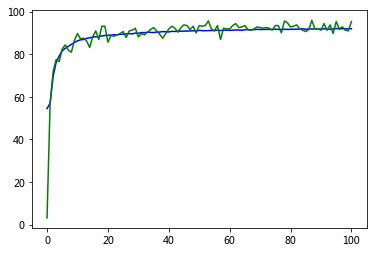

In [37]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.show()

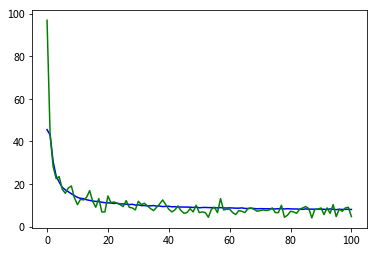

In [38]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [39]:
with tf.Session(graph=graph) as session:
    saver.restore(session, ".ipynb_checkpoints/CNN_multi_all_color_3.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')


INFO:tensorflow:Restoring parameters from .ipynb_checkpoints/CNN_multi_all_color_3.ckpt
Model restored.
Initialized
Done


In [40]:
acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

92.6323844506 92.5650443832
Test accuracy: 92.60


In [ ]:
Below is a simple model v4 (increased number of units)
conv1
lrn
pool1
conv2
lrn
pool2
conv3
lrn
dropout
relu
dropout
read out

In [41]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
#depth3 = 64
num_hidden1 = 512
num_hidden2 = 256
shape = [batch_size, image_size, image_size, num_channels]
dropout = 0.75

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases  = tf.Variable(tf.constant(1.0, shape=[depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases  = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, num_hidden1], stddev=0.1))
    layer3_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
    layer4_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))

    # Read Out layer
    out1_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out2_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out3_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out4_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out5_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data, keep_prob=1.0):
        h_conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID') + layer1_biases)
        lrn = tf.nn.local_response_normalization(h_conv1)
        h_pool1 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, layer2_weights, [1,1,1,1], 'VALID') + layer2_biases)
        lrn = tf.nn.local_response_normalization(h_conv2)
        h_pool2 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, layer3_weights, [1,1,1,1], 'VALID') + layer3_biases)
        lrn = tf.nn.local_response_normalization(h_conv3)
        
        hidden = tf.nn.dropout(h_conv3, keep_prob)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        hidden1 = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        reshape1 = tf.nn.dropout(hidden1, keep_prob)

        logits1 = tf.matmul(reshape1, out1_w) + out1_b
        logits2 = tf.matmul(reshape1, out2_w) + out2_b
        logits3 = tf.matmul(reshape1, out3_w) + out3_b
        logits4 = tf.matmul(reshape1, out4_w) + out4_b
        logits5 = tf.matmul(reshape1, out5_w) + out5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout)
    
    loss_1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1],logits=logits1))
    loss_2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2],logits= logits2))
    loss_3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3],logits=logits3))
    loss_4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4],logits=logits4))
    loss_5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,5],logits=logits5))
    loss   = loss_1+loss_2+loss_3+loss_4+loss_5
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    [tr_logits1, tr_logits2, tr_logits3, tr_logits4, tr_logits5] = model(tf_train_dataset)
    train_prediction = tf.stack([tf.nn.softmax(tr_logits1),\
                                tf.nn.softmax(tr_logits2),\
                                tf.nn.softmax(tr_logits3),\
                                tf.nn.softmax(tr_logits4),\
                                tf.nn.softmax(tr_logits5)])
    
    [v_logits1, v_logits2, v_logits3, v_logits4, v_logits5] = model(tf_valid_dataset)
    valid_prediction = tf.stack([tf.nn.softmax(v_logits1),\
                                tf.nn.softmax(v_logits2),\
                                tf.nn.softmax(v_logits3),\
                                tf.nn.softmax(v_logits4),\
                                tf.nn.softmax(v_logits5)])
    
    [te_logits1, te_logits2, te_logits3, te_logits4, te_logits5] = model(tf_test_dataset)
    test_prediction = tf.stack([tf.nn.softmax(te_logits1),\
                               tf.nn.softmax(te_logits2),\
                               tf.nn.softmax(te_logits3),\
                               tf.nn.softmax(te_logits4),\
                               tf.nn.softmax(te_logits5)])
    saver = tf.train.Saver()


In [42]:
num_steps = 50001

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())  

    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)


        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, ".ipynb_checkpoints/CNN_multi_all_color_9.ckpt")
    print("Model saved in file: %s" % save_path)

#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))
#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 36.971546, Minibatch acc: 3.4%, Validation acc: 54.9%
Step: 500, Minibatch loss: 6.771609, Minibatch acc: 55.0%, Validation acc: 55.2%
Step: 1000, Minibatch loss: 6.337222, Minibatch acc: 56.9%, Validation acc: 55.8%
Step: 1500, Minibatch loss: 5.843881, Minibatch acc: 61.2%, Validation acc: 58.3%
Step: 2000, Minibatch loss: 5.157403, Minibatch acc: 67.2%, Validation acc: 69.6%
Step: 2500, Minibatch loss: 3.686192, Minibatch acc: 78.8%, Validation acc: 78.8%
Step: 3000, Minibatch loss: 3.119199, Minibatch acc: 84.7%, Validation acc: 82.8%
Step: 3500, Minibatch loss: 2.591674, Minibatch acc: 86.2%, Validation acc: 85.3%
Step: 4000, Minibatch loss: 3.232630, Minibatch acc: 84.1%, Validation acc: 86.7%
Step: 4500, Minibatch loss: 2.418040, Minibatch acc: 87.2%, Validation acc: 87.6%
Step: 5000, Minibatch loss: 1.878872, Minibatch acc: 91.9%, Validation acc: 88.2%
Step: 5500, Minibatch loss: 2.192195, Minibatch acc: 87.2%, Validation acc: 89.1%
Step: 60

Step: 49500, Minibatch loss: 0.837285, Minibatch acc: 96.9%, Validation acc: 95.2%
Step: 50000, Minibatch loss: 0.573213, Minibatch acc: 97.8%, Validation acc: 95.4%
Model saved in file: .ipynb_checkpoints/CNN_multi_all_color_9.ckpt
Time to train: 283.66
Model train complete


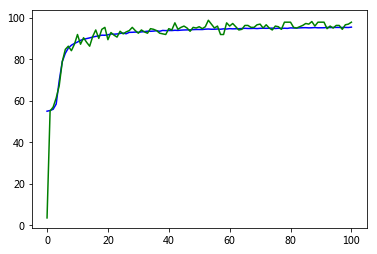

In [43]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.show()

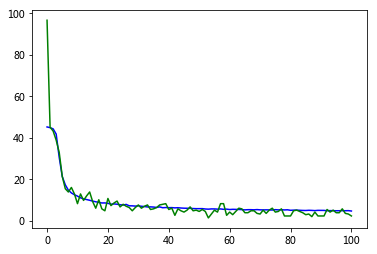

In [44]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [46]:
# load model to calculate accuracy
with tf.Session(graph=graph) as session:
    saver.restore(session, ".ipynb_checkpoints/CNN_multi_all_color_9.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')

acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

INFO:tensorflow:Restoring parameters from .ipynb_checkpoints/CNN_multi_all_color_9.ckpt
Model restored.
Initialized
Done
94.8546066728 94.9280685644
Test accuracy: 94.89


In [ ]:
Below is a simple model v5 (increased number of units, depth)
conv1
lrn
pool1
conv2
lrn
pool2
conv3
lrn
dropout
relu
dropout
read out

In [47]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 3 # color

batch_size = 64
patch_size = 5
depth1 = 32
depth2 = 64
#depth3 = 64
num_hidden1 = 512
num_hidden2 = 256
shape = [batch_size, image_size, image_size, num_channels]
dropout = 0.75

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels  = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset  = tf.constant(test_dataset_0)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1))
    layer1_biases  = tf.Variable(tf.constant(1.0, shape=[depth1]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1))
    layer2_biases  = tf.Variable(tf.constant(1.0, shape=[depth2]))
    layer3_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, num_hidden1], stddev=0.1))
    layer3_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden1]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
    layer4_biases  = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))

    # Read Out layer
    out1_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out2_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out3_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out4_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    out5_w = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    out5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data, keep_prob=1.0):
        h_conv1 = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1,1,1,1], 'VALID') + layer1_biases)
        lrn = tf.nn.local_response_normalization(h_conv1)
        h_pool1 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, layer2_weights, [1,1,1,1], 'VALID') + layer2_biases)
        lrn = tf.nn.local_response_normalization(h_conv2)
        h_pool2 = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME')
        
        h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, layer3_weights, [1,1,1,1], 'VALID') + layer3_biases)
        lrn = tf.nn.local_response_normalization(h_conv3)
        
        hidden = tf.nn.dropout(h_conv3, keep_prob)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden1 = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
        reshape1 = tf.nn.dropout(hidden1, keep_prob)

        logits1 = tf.matmul(reshape1, out1_w) + out1_b
        logits2 = tf.matmul(reshape1, out2_w) + out2_b
        logits3 = tf.matmul(reshape1, out3_w) + out3_b
        logits4 = tf.matmul(reshape1, out4_w) + out4_b
        logits5 = tf.matmul(reshape1, out5_w) + out5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, dropout)
    
    loss_1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1],logits=logits1))
    loss_2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2],logits= logits2))
    loss_3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3],logits=logits3))
    loss_4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4],logits=logits4))
    loss_5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,5],logits=logits5))
    loss   = loss_1+loss_2+loss_3+loss_4+loss_5
    
    # Optimizer.
    #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    [tr_logits1, tr_logits2, tr_logits3, tr_logits4, tr_logits5] = model(tf_train_dataset)
    train_prediction = tf.stack([tf.nn.softmax(tr_logits1),\
                                tf.nn.softmax(tr_logits2),\
                                tf.nn.softmax(tr_logits3),\
                                tf.nn.softmax(tr_logits4),\
                                tf.nn.softmax(tr_logits5)])
    
    [v_logits1, v_logits2, v_logits3, v_logits4, v_logits5] = model(tf_valid_dataset)
    valid_prediction = tf.stack([tf.nn.softmax(v_logits1),\
                                tf.nn.softmax(v_logits2),\
                                tf.nn.softmax(v_logits3),\
                                tf.nn.softmax(v_logits4),\
                                tf.nn.softmax(v_logits5)])
    
    [te_logits1, te_logits2, te_logits3, te_logits4, te_logits5] = model(tf_test_dataset)
    test_prediction = tf.stack([tf.nn.softmax(te_logits1),\
                               tf.nn.softmax(te_logits2),\
                               tf.nn.softmax(te_logits3),\
                               tf.nn.softmax(te_logits4),\
                               tf.nn.softmax(te_logits5)])
    saver = tf.train.Saver()


In [48]:
num_steps = 50001

val_accs=[]
test_accs=[]
minbat_accs=[]

t0 = t.time()

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())  

    print('Initialized')
    for step in range(num_steps):
        #print('step: %d' % step)
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)


        if (step % 500 == 0): 
            minbat_acc=accuracy(predictions, batch_labels[:,1:6])
            minbat_accs.append(minbat_acc)
            val_acc=accuracy(valid_prediction.eval(), valid_labels[:,1:6])
            val_accs.append(val_acc)
            #test_acc=accuracy(test_prediction.eval(), test_labels[:,1:6])
            #test_accs.append(test_acc)
            print('Step: %d, Minibatch loss: %f, Minibatch acc: %.1f%%, Validation acc: %.1f%%' 
                  % (step, l, minbat_acc, val_acc))
            
    #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    save_path = saver.save(session, ".ipynb_checkpoints/CNN_multi_all_color_17.ckpt")
    print("Model saved in file: %s" % save_path)

#
t1=t.time()
print('Time to train: %.2f' %round(t1-t0,3))
#
print("Model train complete")

Initialized
Step: 0, Minibatch loss: 28.935871, Minibatch acc: 15.3%, Validation acc: 46.2%
Step: 500, Minibatch loss: 6.845632, Minibatch acc: 55.0%, Validation acc: 55.2%
Step: 1000, Minibatch loss: 6.228292, Minibatch acc: 58.1%, Validation acc: 57.1%
Step: 1500, Minibatch loss: 5.487132, Minibatch acc: 64.7%, Validation acc: 61.5%
Step: 2000, Minibatch loss: 4.914826, Minibatch acc: 68.8%, Validation acc: 70.9%
Step: 2500, Minibatch loss: 3.649674, Minibatch acc: 78.8%, Validation acc: 78.9%
Step: 3000, Minibatch loss: 3.112357, Minibatch acc: 86.2%, Validation acc: 83.2%
Step: 3500, Minibatch loss: 2.773492, Minibatch acc: 85.3%, Validation acc: 85.1%
Step: 4000, Minibatch loss: 2.891083, Minibatch acc: 84.1%, Validation acc: 87.0%
Step: 4500, Minibatch loss: 2.211080, Minibatch acc: 87.8%, Validation acc: 88.2%
Step: 5000, Minibatch loss: 1.834744, Minibatch acc: 92.5%, Validation acc: 89.0%
Step: 5500, Minibatch loss: 1.877110, Minibatch acc: 90.6%, Validation acc: 89.6%
Step: 6

Step: 49500, Minibatch loss: 0.765549, Minibatch acc: 95.6%, Validation acc: 96.0%
Step: 50000, Minibatch loss: 0.376188, Minibatch acc: 98.1%, Validation acc: 96.0%
Model saved in file: .ipynb_checkpoints/CNN_multi_all_color_17.ckpt
Time to train: 444.41
Model train complete


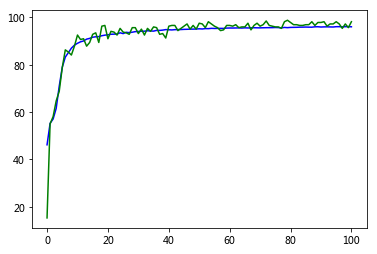

In [49]:
#plot the figure
#plt.plot(range(len(test_accs)),test_accs,'r')
plt.plot(range(len(val_accs)),val_accs,'b')
plt.plot(range(len(minbat_accs)),minbat_accs,'g')
plt.show()

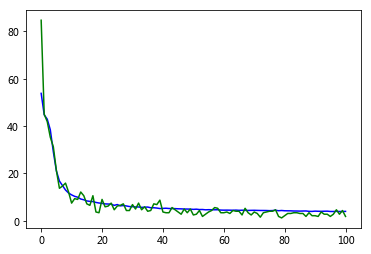

In [50]:
#plot the figure
#plt.plot(range(len(test_accs)),np.ones(len(test_accs))*100-test_accs,'r')
plt.plot(range(len(val_accs)),np.ones(len(val_accs))*100-val_accs,'b')
plt.plot(range(len(minbat_accs)),np.ones(len(minbat_accs))*100-minbat_accs,'g')
plt.show()

In [51]:
with tf.Session(graph=graph) as session:
    saver.restore(session, ".ipynb_checkpoints/CNN_multi_all_color_17.ckpt")
    print("Model restored.")  

    print('Initialized')
    #test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset})
    test_prediction_0 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_0})
    test_prediction_1 = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset_1})
    
    print('Done')

acc_0=accuracy(test_prediction_0, test_labels[0:6534,1:6])
acc_1=accuracy(test_prediction_1, test_labels[6534:13068,1:6])
#acc_all=accuracy(np.concatenate(test_prediction_0[:,:],test_prediction_1[:,:]), test_labels[:,1:6])
print(acc_0,acc_1)#, acc_all)
print('Test accuracy: %.2f'%((acc_0+acc_1)/2.))

INFO:tensorflow:Restoring parameters from .ipynb_checkpoints/CNN_multi_all_color_17.ckpt
Model restored.
Initialized
Done
95.3474135292 95.5004591368
Test accuracy: 95.42


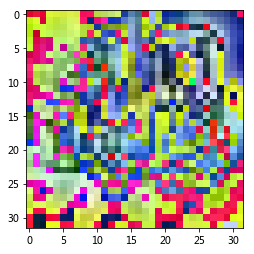

In [54]:
img_test=test_dataset[61]
imgplot = plt.imshow(img_test)
plt.show()

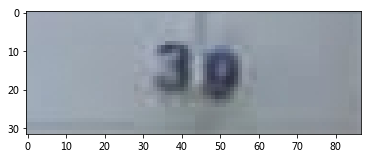

In [68]:
# DEBUG CODE: can be ignored
# print 1st odd image
import os
from PIL import Image
odd_img='4833.png'
fpath=os.path.join('test', odd_img)
my_img=Image.open(fpath)

import matplotlib.pyplot as plt
%matplotlib inline
imgplot=plt.imshow(my_img,cmap='Greys_r')